# Exercise 1

Train a feature-extraction transfer learning model for 10 epochs on the same data and compare its performance vs the model which used featire extraction for 5 epochs and fine-tuning for another 5. Which method is better?

In [2]:
# Get the helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-02-16 17:53:54--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-02-16 17:53:54 (84.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Start with imports from helper_functions
from helper_functions import unzip_data, walk_through_dir, compare_historys, plot_loss_curves

In [4]:
# Other imports
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [5]:
# Check for the GPU
!nvidia-smi

Thu Feb 16 17:53:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    12W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
# Getting the dataset 
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data('101_food_classes_10_percent.zip')

--2023-02-16 17:53:58--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  21.5MB/s    in 72s     

2023-02-16 17:55:10 (21.5 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [7]:
# Creating paths to train and test directories
train_dir = '101_food_classes_10_percent/train'
test_dir = '101_food_classes_10_percent/test'

In [8]:
# Checking the amount of items
walk_through_dir('101_food_classes_10_percent')

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/shrimp_and_grits'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/miso_soup'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/edamame'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/spaghetti_carbonara'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/ravioli'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/panna_cotta'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/spaghetti_bolognese'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/caprese_salad'.
There are 0 directories 

In [54]:
# Setup data inputs
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir, 
                                                                 label_mode='categorical',
                                                                 image_size=(224,224), 
                                                                 batch_size=32)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=(224, 224),
                                                                shuffle=False,
                                                                batch_size=32)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [55]:
# Creating data augmentation layer (or model, to be precise) to enhance the performance
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

In [56]:
# Setting up data augmentation
data_augmentation_model = Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2)
], name='data_augmentation')

In [57]:
# Setting up the base model and freezing all the layers
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

In [58]:
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

Compute dtype: float32
Variable dtype: float32


In [59]:
# Create the architecture of the model including inputs, augmentation and outputs
inputs = layers.Input(shape=(224, 224, 3), name='input_layer')
x = data_augmentation_model(inputs) # augmenting happens during training phase -> base data untouched
x = base_model(x, training=False) # makes base model frozen -> inference mode; weights do not get updated
x = layers.GlobalAveragePooling2D(name='global_average_pooling')(x)
outputs = layers.Dense(len(train_data.class_names), activation='softmax', name='output_layer', dtype='float32')(x)
model = tf.keras.Model(inputs, outputs)

In [60]:
# Checking out the summary of the model
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-train

In [61]:
# Compiling the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [62]:
# Fitting the model for 10 epochs
training_time = 5

model_history = model.fit(train_data,
                          epochs=training_time,
                          steps_per_epoch=len(train_data),
                          validation_data=test_data,
                          validation_steps=int(0.15*len(test_data)),
                          verbose=2)

Epoch 1/5


237/237 - 120s - loss: 3.3696 - accuracy: 0.2734 - val_loss: 2.4538 - val_accuracy: 0.4722 - 120s/epoch - 506ms/step
Epoch 2/5
237/237 - 92s - loss: 2.2007 - accuracy: 0.5036 - val_loss: 2.0316 - val_accuracy: 0.5143 - 92s/epoch - 389ms/step
Epoch 3/5
237/237 - 90s - loss: 1.8125 - accuracy: 0.5663 - val_loss: 1.8822 - val_accuracy: 0.5291 - 90s/epoch - 378ms/step
Epoch 4/5
237/237 - 85s - loss: 1.5980 - accuracy: 0.6120 - val_loss: 1.8038 - val_accuracy: 0.5408 - 85s/epoch - 357ms/step
Epoch 5/5
237/237 - 82s - loss: 1.4470 - accuracy: 0.6412 - val_loss: 1.7602 - val_accuracy: 0.5524 - 82s/epoch - 344ms/step


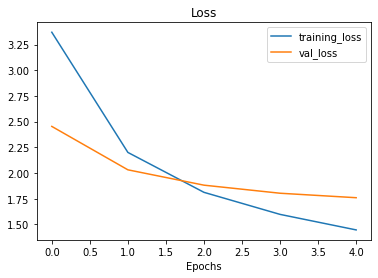

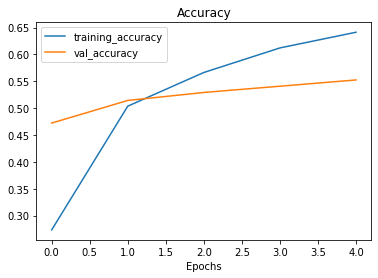

In [63]:
# One more import needed
plot_loss_curves(model_history)

In [64]:
# Check which layers are trainable
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 False
global_average_pooling True
output_layer True


In [65]:
# Evaluating the model
model.evaluate(test_data)

790/790 [==============================] - 56s 71ms/step - loss: 1.5771 - accuracy: 0.5872


[1.5771257877349854, 0.5872475504875183]

## Answer
Comparing two of the methods - 5 epochs of feature extraction and 5 epochs of fine-tuning compared to 10 epochs of only feature extraction - it's easy to see that they provide similar outputs in regard of raw numbers.

First one outputted validation metrics of loss equal to 1.48 and accuracy of 60.75% with the latter performing similarly at 1.51 validation loss nad 59.46% of validation accuracy.


# Exercise 2
Recreate the first model (feature extraction) with mixed precision turned on. 

In [53]:
# Float16 policy?
from tensorflow.keras import mixed_precision

policy = mixed_precision.Policy('float32')
mixed_precision.set_global_policy(policy)

In [37]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-a87869f6-642d-85a8-1cdb-81ef5a9a98ab)


After running these two cells, run the whole notebook from the start up until evaluating phase.

## Answers
**Q:** Does it make the model train faster?
> A: It should, however the bigger the dataset, bigger the impact of using the *float16 mixed precision parameter*.

**Q:** Does it affect the accuracy or performance of our model?
> A: It should not.

**Q:** What's the advantage of using `mixed_precision` training?
> A: Better utilization of GPUs memory and lowering the total time of practice.